In [7]:
import pandas as pd
import matplotlib.pyplot as plt

### Let's first import all the csv files... the "instagram_posts.csv" file is too big, so we will read it by chunks.
### We will also see if we can lighten the memory a bit by defining the data types of the csv file in andvance, but first we need to analyze the content of a portion of the whole file

In [2]:
%%time
post = pd.read_csv("instagram_posts.csv", delimiter="\t", chunksize=2000000)

Wall time: 18 ms


In [3]:

%%time
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")

Wall time: 16.2 s


In [4]:
%%time
location = pd.read_csv("instagram_locations.csv", delimiter = "\t")

Wall time: 6.8 s


## PreProcessing Instagram Posts

In [5]:
p = post.get_chunk(2000000)

In [31]:
#p1 without any dtype setting
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 1 to 2000000
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   sid              int64  
 1   sid_profile      int64  
 2   post_id          object 
 3   profile_id       float64
 4   location_id      float64
 5   cts              object 
 6   post_type        int64  
 7   description      object 
 8   numbr_likes      int64  
 9   number_comments  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 152.6+ MB


In [30]:
#check to see if there are any duplicated rows!
duplicate_row_p1 = p[p.duplicated()]
duplicate_row_p1.shape

(0, 10)

### Find all the unique value of each row

In [40]:
#TODO: redo with appropriate function
for columns in p:
    if columns != 'description':
        print(columns, " : ", p[columns].unique().shape, "max: ", p1[columns].unique().max(), "min: ", p1[columns].unique().min())



sid  :  (2000000,) max:  30419436 min:  6025
sid_profile  :  (99813,) max:  4510554 min:  -1
post_id  :  (2000000,) max:  zzv4K5vNWp min:  ---dcJLfEG
profile_id  :  (1486596,) max:  nan min:  nan
location_id  :  (89578,) max:  nan min:  nan
cts  :  (1797406,) max:  2019-06-02 15:31:49.000 min:  2010-09-05 21:48:24.000
post_type  :  (3,) max:  3 min:  1
numbr_likes  :  (14469,) max:  2212264 min:  0
number_comments  :  (1513,) max:  135221 min:  0


As you can see we have some Na in the profile_id columsn, and the location_id.
While the value "Na" in the location_id might simply suggest the absense of it in the post, one post should't have a missing "profile_id".
To solve this dirty data we decided to drop every post who has not a valid profile_id 

In [50]:
#We drop all the na in the column 'profile_id'
p = p.dropna(subset= ['profile_id'])
#We print the min and the max of all the attributes
for columns in p:
    if columns != 'description':
        print(columns, " : ", p[columns].unique().shape, "max: ", p[columns].unique().max(), "min: ", p[columns].unique().min())

sid  :  (1999863,) max:  30419436 min:  6025
sid_profile  :  (99813,) max:  4510554 min:  -1
post_id  :  (1999863,) max:  zzv4K5vNWp min:  ---dcJLfEG
profile_id  :  (1486595,) max:  14445760345.0 min:  3.0
location_id  :  (89575,) max:  nan min:  nan
cts  :  (1797288,) max:  2019-06-02 15:31:49.000 min:  2010-09-05 21:48:24.000
post_type  :  (3,) max:  3 min:  1
numbr_likes  :  (14468,) max:  2212264 min:  0
number_comments  :  (1513,) max:  135221 min:  0


As we can see, we can modify the memory of a few columns, in particular:
- number_comments has a range going from 0 to 135221 so we can use the int32
- numbr_likes has a range going from 0 to 135221 so we can use the int32
- post_likes rappresents only 3 possibility, so a categorical feature should be good enough
- sid_profile has a range going from -1 to 4510554 so we can use the int32
- sid has a range going from 6025 to 30419436 so we can use the int 32

In [71]:
dtypes = {
    'sid': 'int32',
    'sid_profile': 'int32',
    'post_id':'object',
    'profile_id': 'float64',
    'location_id': 'float64',
    'cts' : 'object',
    'post_type' : 'category',
    'numbr_likes': 'int32',
    'number_comments':'int32'
}

post = pd.read_csv("instagram_posts.csv", delimiter="\t", chunksize=2000000, dtype=dtypes)
p_clean = post.get_chunk(2000000)
p_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   sid              int32   
 1   sid_profile      int32   
 2   post_id          object  
 3   profile_id       float64 
 4   location_id      float64 
 5   cts              object  
 6   post_type        category
 7   description      object  
 8   numbr_likes      int32   
 9   number_comments  int32   
dtypes: category(1), float64(2), int32(4), object(3)
memory usage: 108.7+ MB


We went from 152MB to 109 MB for the same chunk. But we can do better by managing the Na Values!

In [72]:
#Managing the Na value in the "profile_id" column and the "location_id"
#as we said before, we are gonna drop all the na in the "profile_id" column
p_clean = p_clean.dropna(subset= ['profile_id'])
#and we are gonna replace all the missing values from location_id to 0
p_clean['location_id'] = p_clean['location_id'].fillna(0)

In [73]:

p_clean = p_clean.astype({'location_id': 'int64', 'profile_id': 'int64'})
p_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999863 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   sid              int32   
 1   sid_profile      int32   
 2   post_id          object  
 3   profile_id       int64   
 4   location_id      int64   
 5   cts              object  
 6   post_type        category
 7   description      object  
 8   numbr_likes      int32   
 9   number_comments  int32   
dtypes: category(1), int32(4), int64(2), object(3)
memory usage: 124.0+ MB


## Preprocessing Profiles

In [25]:
profiles.head()

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
0,4184446,4.721050e+09,jphillip033,John Pierce,"""Document Everything Always""",250.0,146.0,170.0,NaN,2019-08-01 14:38:55.394 -0400,False
1,4184457,5.905830e+08,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534.0,1145.0,2878.0,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526 -0400,False
2,4184460,1.074147e+09,yellowlightbreen,Eliza Gray,Maine is for Lovers,469.0,324.0,431.0,elizajanegray.com,2019-08-01 14:39:54.407 -0400,False
3,4184461,1.472039e+09,tec1025,Thomas Clark,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:06.472 -0400,NaN
4,4184462,3.531421e+09,luckyfluff,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:07.806 -0400,NaN


In [4]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509586 entries, 0 to 4509585
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   sid                  int64  
 1   profile_id           float64
 2   profile_name         object 
 3   firstname_lastname   object 
 4   description          object 
 5   following            float64
 6   followers            float64
 7   n_posts              float64
 8   url                  object 
 9   cts                  object 
 10  is_business_account  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 378.5+ MB


I check in order:
- If there are any duplicates
- If there are any Na Values
- If the dataset can be stored in a more efficient way

## Check for duplicates

In [6]:
#checking for duplicates
profiles_dup = profiles[profiles.duplicated()]
print(profiles_dup.shape)


(0, 11)


## Check and Deal with Na values

11 columns and 0 rows, it means there are no duplicates

In [11]:
#check for Na inside the dataframe
#the Na values can be "stored" only in float64 dtype, so i will need to check only the float64
for column in profiles:
    print(column, " :", profiles[column].isnull().values.sum())


sid  : 0
profile_id  : 32447
profile_name  : 0
firstname_lastname  : 288465
description  : 2055996
following  : 1056815
followers  : 1056815
n_posts  : 1056815
url  : 3639312
cts  : 438488
is_business_account  : 1064263


In [34]:
Na = profiles[profiles['firstname_lastname'].isna()]
Na.head()

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
4,4184462,3.531421e+09,luckyfluff,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:07.806 -0400,NaN
39,4184499,5.134539e+08,na3ir_lowlif3,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:42:12.370 -0400,NaN
83,4184533,2.940533e+09,bertanooguera__,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:43:15.857 -0400,NaN
95,4184552,1.112121e+10,fhs_fbla2019,NaN,Fulton High School FBLA🐝,0.0,17.0,9.0,NaN,2019-08-01 14:44:36.516 -0400,False
121,4184579,1.464425e+09,evgray_baseball3,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:46:12.921 -0400,NaN


## Check for differente data types

In [39]:
profiles.describe().T

,count,mean,std,min,25%,50%,75%,max
sid,4509586.0,2.255992e+06,1.301807e+06,1186.0,1.128596e+06,2.255992e+06,3.383389e+06,4.510785e+06
profile_id,4477139.0,3.083302e+09,4.266575e+10,4.0,2.735177e+08,1.649248e+09,5.514691e+09,9.001013e+13
following,3452771.0,1.405641e+03,8.113473e+03,0.0,3.560000e+02,7.540000e+02,1.573000e+03,4.191080e+06
followers,3452771.0,4.739899e+03,1.939087e+05,0.0,1.590000e+02,4.060000e+02,9.740000e+02,2.854576e+08
n_posts,3452771.0,4.095414e+02,1.041940e+03,0.0,2.200000e+01,1.200000e+02,4.200000e+02,1.837300e+05


In [19]:
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022658 entries, 0 to 1022657
Data columns (total 23 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   sid                     1022658 non-null  int64  
 1   id                      1022658 non-null  int64  
 2   name                    1022658 non-null  object 
 3   street                  715704 non-null   object 
 4   zip                     715579 non-null   object 
 5   city                    937166 non-null   object 
 6   region                  1760 non-null     object 
 7   cd                      939010 non-null   object 
 8   phone                   601688 non-null   object 
 9   aj_exact_city_match     1000510 non-null  object 
 10  aj_exact_country_match  1000510 non-null  object 
 11  blurb                   406705 non-null   object 
 12  dir_city_id             495698 non-null   object 
 13  dir_city_name           495698 non-null   object 
 14  di

## Data Visualizzation

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
0,28370919,3496776,BXdjjUlgcgq,2.237948e+09,1.022366e+15,2017-08-06 20:06:57.000,2,Wreckloose! Deevalley bike park laps on the @i...,80,0
1,28370932,-1,BVg0pbolYBC,5.579335e+09,4.574268e+14,2017-06-19 09:31:16.000,1,🙌🏼 believe in ya dreams 🙌🏼 just like I believe...,25,1
2,28370933,-1,BRgkjcXFp3Q,3.134296e+08,4.574268e+14,2017-03-11 20:05:03.000,1,#meraviglia #incensi #the #candele #profumo #a...,9,0
3,28370934,-1,BKTKeNhjEA7,1.837593e+09,4.574268e+14,2016-09-13 16:27:16.000,1,#teatime #scorpion #friends #love #mountains #...,4,0
4,28370935,-1,8-NQrvoYLX,1.131527e+09,4.574268e+14,2015-10-18 10:19:27.000,1,thE sky gavE mE a #constEllation,8,0
...,...,...,...,...,...,...,...,...,...,...
1999995,30401422,-1,Bv4gjUCAWx9,3.913883e+09,3.307338e+14,2019-04-05 19:53:41.000,1,Empieza otra de esas noches de producto en Res...,81,1
1999996,30401423,-1,Bv11KOwga_E,3.264045e+08,3.307338e+14,2019-04-04 18:56:02.000,1,Rodaballo espectacular de 5 kg. A Disfrutar en...,49,0
1999997,30401424,-1,BvzfR-MjqLZ,3.356828e+08,3.307338e+14,2019-04-03 21:06:22.000,1,Impecable el codillo limpito y preparao en un ...,44,5
1999998,30401425,-1,Bvg6eyOgJs9,3.913883e+09,3.307338e+14,2019-03-27 14:58:29.000,1,Cuchara Power en Restaurante albalat! Hoy Lent...,55,0


In [12]:
c = p['post_type'].value_counts()


1    1877778
2     122216
3          6
Name: post_type, dtype: int64

Let's display the different types of posts

([<matplotlib.patches.Wedge at 0x23a2531cb20>,
 [Text(-1.079789992625052, 0.2098894276203312, 'Photo'),
  Text(1.0797880323641327, -0.2098995120604019, 'Video'),
  Text(1.0999999999529024, -1.0179135715872946e-05, 'dont_remember')])

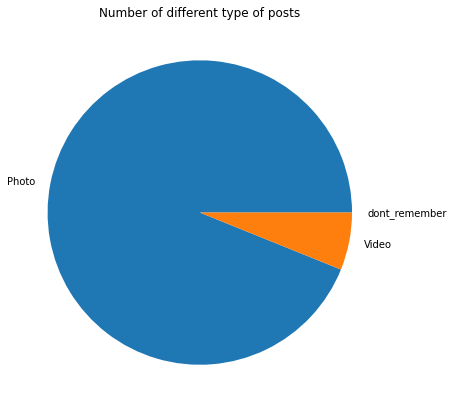

In [19]:
fig = plt.figure(figsize =(10, 7))
plt.title("Number of different type of posts")
plt.pie(c, labels=['Photo', 'Video', ' '])

Lets plot the number of post with the same number of likes

In [35]:
same_likes = p['numbr_likes'].value_counts()

(array([1.4144e+04, 7.8000e+01, 4.2000e+01, 3.9000e+01, 1.3000e+01,
        1.4000e+01, 1.1000e+01, 1.6000e+01, 1.5000e+01, 1.0000e+01,
        1.3000e+01, 4.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00]),
 array([1.000000e+00, 5.839800e+02, 1.166960e+03, 1.749940e+03,
        2.332920e+03, 2.915900e+03, 3.498880e+03, 4.081860e+03,
        4.664840e+03, 5.247820e+03, 5.830800e+03, 6.413780e+03,
        6.996760e+03, 7.579740e+03, 8.162720e+03, 8.745700e+03,
        9.328680e+03, 9.911660e+03, 1.049464e+04, 1.107762e+04

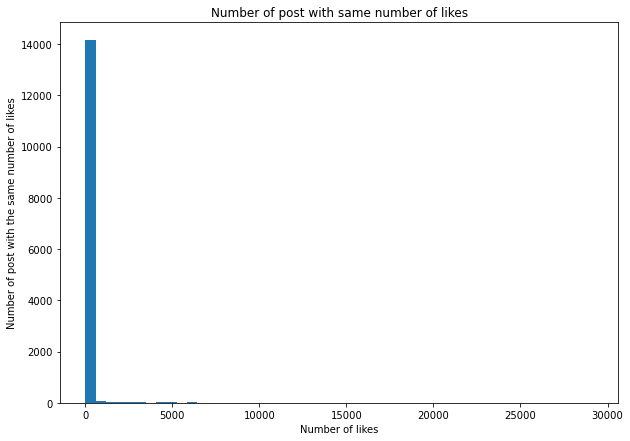

In [36]:
fig = plt.figure(figsize =(10, 7))
plt.title("Number of post with same number of likes")
plt.xlabel("Number of likes")
plt.ylabel("Number of post with the same number of likes")
plt.hist(same_likes, bins = 50)

Scatterplot between the number of likes and the number of comments

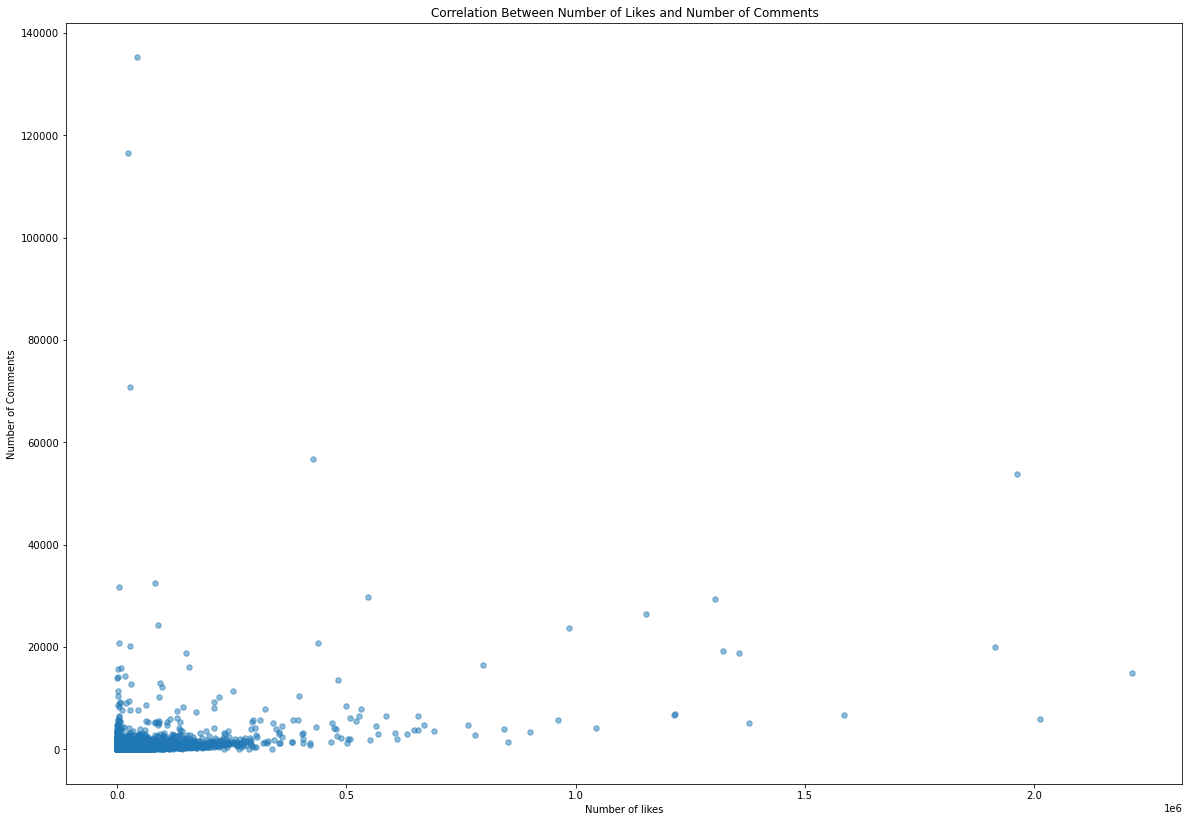

In [54]:
fig = plt.figure(figsize =(20, 14))
plt.scatter(p['numbr_likes'], p['number_comments'],s=30, alpha=0.5)
plt.xlabel("Number of likes")
plt.ylabel("Number of Comments")
plt.title("Correlation Between Number of Likes and Number of Comments")
plt.show()

In [39]:
profiles

,sid,profile_id,profile_name,firstname_lastname,description,following,followers,n_posts,url,cts,is_business_account
0,4184446,4.721050e+09,jphillip033,John Pierce,"""Document Everything Always""",250.0,146.0,170.0,NaN,2019-08-01 14:38:55.394 -0400,False
1,4184457,5.905830e+08,mama_haas,Deanna,Trying to enjoy the simple things in life. Kni...,534.0,1145.0,2878.0,www.etsy.com/shop/MamaHaas69,2019-08-01 14:39:36.526 -0400,False
2,4184460,1.074147e+09,yellowlightbreen,Eliza Gray,Maine is for Lovers,469.0,324.0,431.0,elizajanegray.com,2019-08-01 14:39:54.407 -0400,False
3,4184461,1.472039e+09,tec1025,Thomas Clark,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:06.472 -0400,NaN
4,4184462,3.531421e+09,luckyfluff,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:07.806 -0400,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4509581,4184467,1.418322e+09,karenarkesteyn,Karen Arkesteyn,🙏🏻,468.0,481.0,497.0,NaN,2019-08-01 14:40:26.554 -0400,False
4509582,4184469,1.340704e+07,jornvlaeminck,Jorn Vlaeminck,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:41.628 -0400,NaN
4509583,4184470,6.007354e+09,s_degol,Sanne Degol,NaN,NaN,NaN,NaN,NaN,2019-08-01 14:40:42.983 -0400,NaN
4509584,4184473,2.338990e+07,anwilms,An Wilms,Fashion - travel - photography ... that's me!👗...,504.0,153.0,183.0,NaN,2019-08-01 14:40:49.982 -0400,False


Correlation Between the number of followers and the number of following

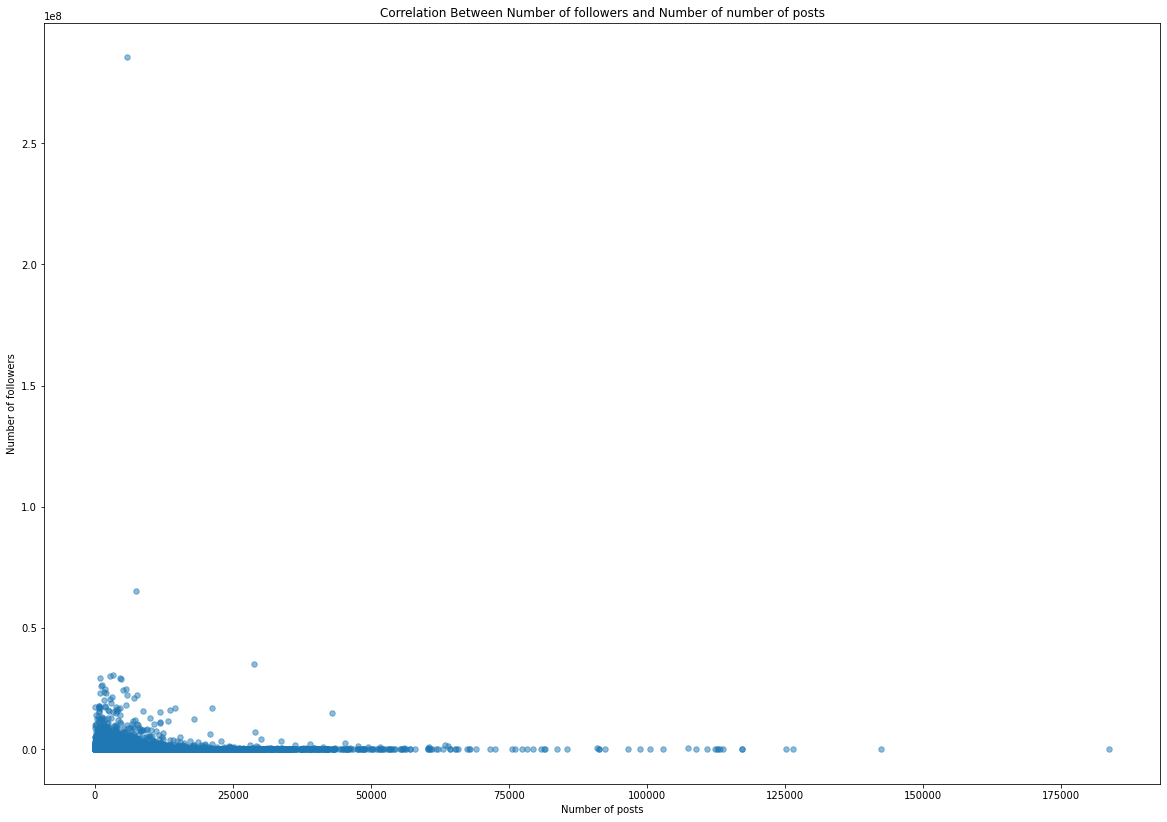

In [53]:
fig = plt.figure(figsize =(20, 14))
plt.scatter(profiles['n_posts'], profiles['followers'],s=30, alpha=0.5)
plt.xlabel("Number of posts")
plt.ylabel("Number of followers")
plt.title("Correlation Between Number of posts and Number of number of followers")
plt.show()

Let's plot the business and non business account

In [56]:
is_business = profiles['is_business_account'].value_counts()

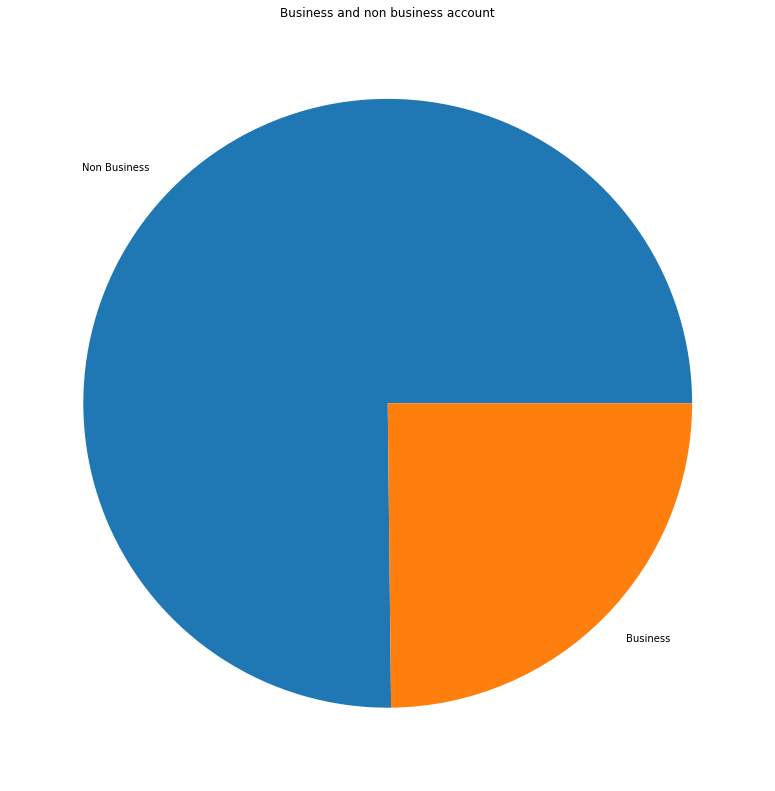

In [98]:
fig = plt.figure(figsize =(10, 7))
plt.title("Business and non business account")
plt.pie(is_business, labels=['Non Business', 'Business'])
plt.show()

Let's plot how many have an URL in their profiles

In [78]:
#count how many don't have an url in their profiles
not_url = profiles['url'].isna().sum()

#count how many have an url in their profile
have_url = profiles['url'].shape[0] - not_url

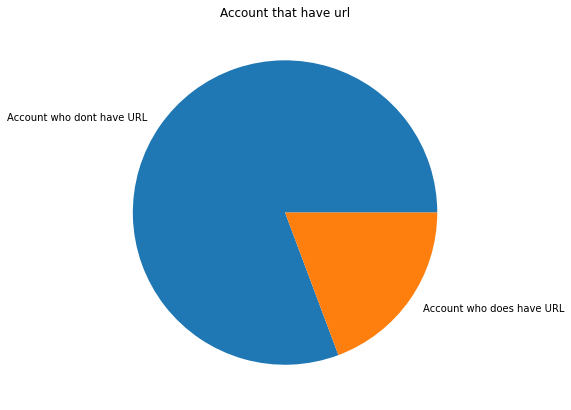

In [86]:
fig = plt.figure(figsize =(10, 7))
plt.title("Account that have url")
plt.pie([not_url, have_url], labels=['Account who dont have URL', 'Account who does have URL'])
plt.show()

In [83]:
location

,sid,id,name,street,zip,city,region,cd,phone,aj_exact_city_match,...,dir_city_name,dir_city_slug,dir_country_id,dir_country_name,lat,lng,primary_alias_on_fb,slug,website,cts
0,719981,110296492939207,"Playa de Daimuz - Valencia, España",NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,-0.139475,38.974391,daimuzplaya,playa-de-daimuz-valencia-espana,https://es.wikipedia.org/wiki/Daimuz,2019-05-29 01:21:29.987
1,719983,274391278,Nová Vieska,NaN,NaN,Nová Vieska,NaN,SK,NaN,True,...,Kis-Újfalu,kis-ujfalu,SK,Slovakia,18.466667,47.866667,NaN,nova-vieska,NaN,2019-05-29 01:21:38.037
2,719985,148885595789195,Everest Today,Himalayas,+977,"Kathmandu, Nepal",NaN,NP,NaN,False,...,Pasupati,pasupati,NP,Nepal,85.330150,27.701960,EverestToday,everest-today,NaN,2019-05-29 01:21:46.295
3,719987,263258277,BULAC - Bibliothèque universitaire des langues...,"65, rue des Grands-Moulins",75013,"Paris, France",NaN,FR,01 81 69 18 00,False,...,13ème Arrondissement Paris,13eme-arrondissement-paris,FR,France,2.375995,48.827240,BULAC.Paris,bulac-bibliotheque-universitaire-des-langues-e...,www.bulac.fr,2019-05-29 01:21:54.355
4,326443,406147529857708,ABC Cable Networks Group,3800 W Alameda Ave,91505,"Burbank, California",NaN,US,(818) 569-7500,False,...,NaN,NaN,NaN,NaN,-118.341864,34.153265,NaN,abc-cable-networks-group,NaN,2019-04-02 15:22:55.703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022653,719973,873926439475785,Baby Season,Suarez de Figueroa # 380,NaN,"Santa Cruz de la Sierra, Bolivia",NaN,BO,69118383,False,...,Santa Cruz de la Sierra,santa-cruz-de-la-sierra,BO,Bolivia,-63.185307,-17.786130,babyseason.srl,baby-season,NaN,2019-05-29 01:20:57.078
1022654,719975,390707529,Cueva Carvajal,NaN,NaN,NaN,NaN,NaN,+52 81 2089 7776,NaN,...,NaN,NaN,NaN,NaN,-100.359619,25.653550,CuevaCarvajalBrewPub,cueva-carvajal,http://www.cuevacarvajal.mx,2019-05-29 01:21:04.434
1022655,719977,1205466612894741,The Cheesecake Factory,304 Orland Square Dr,60462,"Orland Park, Illinois",NaN,US,(708) 873-3747,False,...,Manor Homes,manor-homes,US,United States,-87.843649,41.618551,NaN,the-cheesecake-factory,http://locations.thecheesecakefactory.com/il/o...,2019-05-29 01:21:13.404
1022656,719979,286794844,Plimmer Towers,2 Gilmer Terrace,NaN,"Wellington, New Zealand",NaN,NZ,NaN,False,...,NaN,NaN,NaN,NaN,174.775000,-41.285800,NaN,plimmer-towers,NaN,2019-05-29 01:21:21.628


Lets plot how many posts there are for each country

In [100]:
countCountry = location['cd'].value_counts()


countCountry.shape

(245,)

In [109]:
def my_autopct(pct):
    return (pct) if pct > 200 else ''

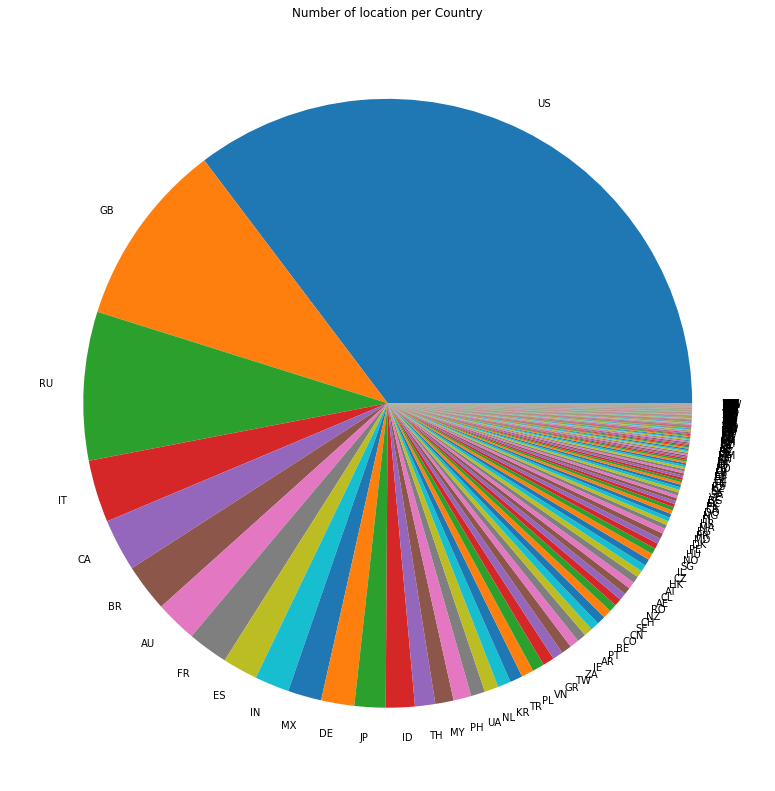

In [112]:
fig = plt.figure(figsize =(20, 14))

plt.title("Number of location per Country")
plt.pie(countCountry, labels=countCountry.index, autopct=lambda p: format(p, '.2f') if p > 1000 else None)
plt.show()

In [ ]:
from functions import *

